## **Objective: The objective of this project is to develop a Support Vector Machine (SVM) model capable of classifying Apple quality.**

# **Import the data**

In [2]:
import pandas as pd
data = pd.read_csv("D:/Dataset/apple_quality_dataset/apple_quality.csv")

# **Data Preprocessing**

In [3]:
data.shape

(4001, 9)

In [4]:
data.head(5)

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


**Check for missing data**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


In [6]:
# drop some useless information
data = data.dropna()
data.drop('A_id', axis = 1, inplace = True)


In [7]:
print(data['Quality'].value_counts())

Quality
good    2004
bad     1996
Name: count, dtype: int64


**Feature Encoding**

In [8]:
data['Quality'] = data['Quality'].map({'good': 1, 'bad': 0})

**Check for correlations**

In [9]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["Quality"].sort_values(ascending=False)

Quality        1.000000
Juiciness      0.260223
Sweetness      0.250998
Size           0.244007
Weight         0.001421
Crunchiness   -0.012376
Ripeness      -0.264315
Name: Quality, dtype: float64

> hmm.. doesn't look like there is any correlation between the quality and the other features.

# **Machine Learning Model**

**Split the data**

In [10]:
# split the data
from sklearn.model_selection import train_test_split

X = data.drop("Quality", axis=1)
y = data["Quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



**Using Linear SVM**

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler # normalization
from sklearn.svm import LinearSVC

linear_svc_clf = make_pipeline(StandardScaler(), LinearSVC(C=1, random_state=42, dual=False))

# train the model
linear_svc_clf.fit(X_train, y_train)

# evaluate the trained model
train_score = linear_svc_clf.score(X_train, y_train)

# evaluate the model on unseen data
test_score = linear_svc_clf.score(X_test, y_test)

print(f"train score: {train_score:.2%}")
print(f"test score: {test_score:.2%}")


train score: 74.44%
test score: 75.88%


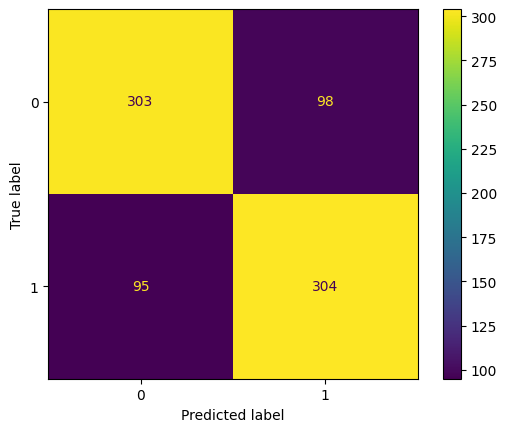

In [12]:
# plot model performance
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(linear_svc_clf, X_test, y_test)
plt.show()

> Despite a higher number of correctly classified values compared to incorrectly classified ones, the overall performance of the model remains inadequate.

> Since the model here is underfitting (linear = very simple) let's change the hyperparameters and see if we can improve it.

In [13]:
# hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {
    'linearsvc__C': [0.001, 0.01, 0.1, 1, 10],
}

linear_svc_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=42, dual=False))
grid_search = GridSearchCV(linear_svc_clf, param_grid, scoring='accuracy')


grid_search.fit(X_train, y_train)

best_param = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_param)
print(f"Best Score: {best_score:.2%}")

Best Parameters: {'linearsvc__C': 0.1}
Best Score: 74.47%


> The model is still underfitting. SO let's try another classifier.

**Using Polynomial Features for Linear SVM**

In [14]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=4), # I tested it with higher degrees but the model started overfitting.
    StandardScaler(),
    LinearSVC(C=1, random_state=42, dual=False)
    )

# train the model
polynomial_svm_clf.fit(X_train, y_train)

# evaluate the trained model
poly_Features_train_score = polynomial_svm_clf.score(X_train, y_train)

# evaluate the model on unseen data
poly_Features_test_score = polynomial_svm_clf.score(X_test, y_test)

print(f"train score: {poly_Features_train_score:.2%}")
print(f"test score: {poly_Features_test_score :.2%}")

train score: 95.41%
test score: 93.00%


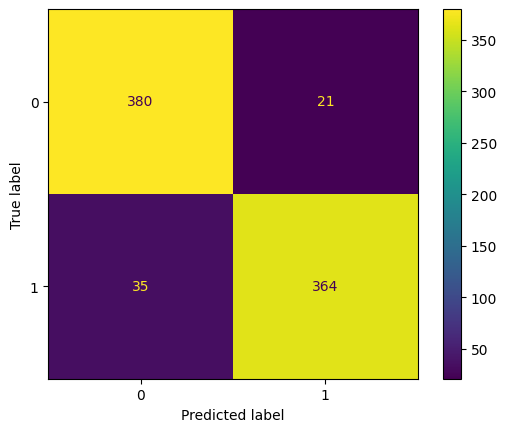

In [15]:
# plot model performance
ConfusionMatrixDisplay.from_estimator(polynomial_svm_clf, X_test, y_test)
plt.show()

> This is more convincing than the previous classifier..

**Using RBF Kernel**

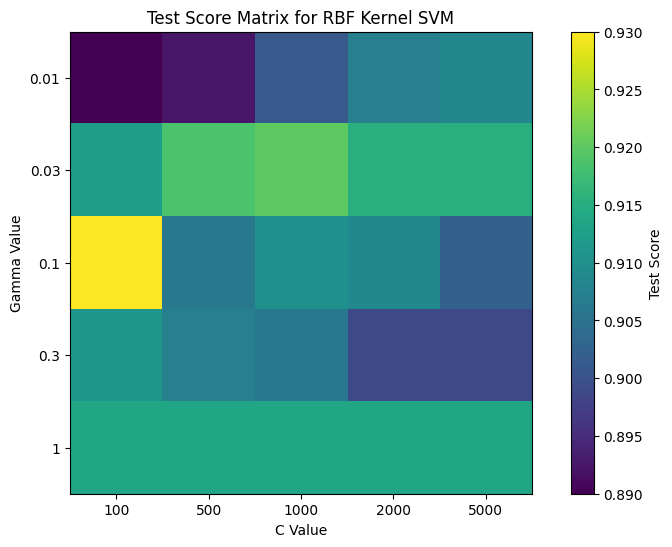

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Define the range of gamma and C values to test
gamma_values = [0.01, 0.03, 0.1, 0.3, 1]
C_values = [100, 500, 1000, 2000, 5000]
test_scores_matrix = np.zeros((len(gamma_values), len(C_values)))

# Iterate over each combination of gamma and C values
for i, gamma in enumerate(gamma_values):
    for j, C in enumerate(C_values):
        # Define the pipeline with the current gamma and C values
        RBF_kernel_svm_clf = make_pipeline(
            StandardScaler(),
            SVC(kernel="rbf", gamma=gamma, C=C)
        )

        # Train the model
        RBF_kernel_svm_clf.fit(X_train, y_train)

        # Evaluate the model on the test set
        test_score = RBF_kernel_svm_clf.score(X_test, y_test)
        test_scores_matrix[i, j] = test_score

# Plot the matrix
plt.figure(figsize=(10, 6))
plt.imshow(test_scores_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Test Score')
plt.xticks(np.arange(len(C_values)), C_values)
plt.yticks(np.arange(len(gamma_values)), gamma_values)
plt.xlabel('C Value')
plt.ylabel('Gamma Value')
plt.title('Test Score Matrix for RBF Kernel SVM')
plt.show()


In [55]:
poly_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=.1, C=100)
)

# train the model
poly_kernel_svm_clf.fit(X_train, y_train)

# evaluate the trained model
RBF_kernel_train_score = poly_kernel_svm_clf.score(X_train, y_train)

# evaluate the model on unseen data
RBF_kernel_test_score  = poly_kernel_svm_clf.score(X_test, y_test)

print(f"train score: {RBF_kernel_train_score:.2%}")
print(f"test score: {RBF_kernel_test_score:.2%}")

train score: 94.72%
test score: 93.00%


**Using polynomial Kernel**

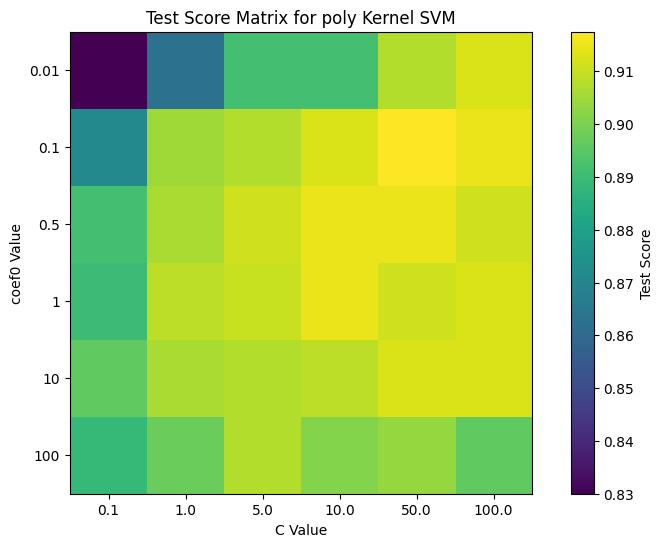

In [53]:
# This cell takes about 14 minutes to run

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

coef0_values = [0.01, 0.1, 0.5, 1, 10, 100]
C_vals = [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
test_scores_matrix = np.zeros((len(coef0_values), len(C_vals)))


for i, coef0 in enumerate(coef0_values):
    for j, C in enumerate(C_vals):
        poly_kernel_svm_clf = make_pipeline(
            StandardScaler(),
            SVC(kernel="poly", coef0=coef0, C=C)
        )
        poly_kernel_svm_clf.fit(X_train, y_train)
        test_score = poly_kernel_svm_clf.score(X_test, y_test)
        test_scores_matrix[i, j] = test_score

plt.figure(figsize=(10, 6))
plt.imshow(test_scores_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Test Score')
plt.xticks(np.arange(len(C_vals)), C_vals)
plt.yticks(np.arange(len(coef0_values)), coef0_values)
plt.xlabel('C Value')
plt.ylabel('coef0 Value')
plt.title('Test Score Matrix for poly Kernel SVM')
plt.show()


In [59]:
poly_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", coef0=.1 ,C=50)
)
poly_kernel_svm_clf.fit(X_train, y_train)

poly_kernel_train_score = poly_kernel_svm_clf.score(X_train, y_train)
poly_kernel_test_score  = poly_kernel_svm_clf.score(X_test, y_test)

print(f"train score: {poly_kernel_train_score:.2%}")
print(f"test score: {poly_kernel_test_score:.2%}")

train score: 91.25%
test score: 91.75%


>Overall, based on the difference between the test and train scores, the best classifier is the RBF Kernel SVM with C = 100 and gamma = 0.1

> train score: 94.72%
test score: 93.00%


> This classifier has the same test result as using polynomial features for linear SVM. However It is less overfitting.